1. Setup and Load Data

1.1 Install Dependencies and Setup

!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [2]:
#Limit GPU consumption

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1.2 Load Data

In [3]:
data_dir = 'Eye_diseases'

In [4]:
os.listdir(data_dir)

['Cataracts', 'eye_detection.ipynb', 'Jaundice', 'Normal', 'Uveitis']

In [5]:
#Accesses the folder where my images are being kept in 4 folders labelled by their conditions.

data = tf.keras.utils.image_dataset_from_directory('Eye_diseases').repeat(20)

Found 217 files belonging to 4 classes.


In [6]:
#Allows me to loop through the newly created dataset

data_iterator = data.as_numpy_iterator()

In [7]:
#Creates a batch of 32 images that I can pull from the iterator

batch = data_iterator.next()

In [8]:
#Shows that I have 32 images in the batch that are 256 x 256 pixels and in color

batch[0].shape

(32, 256, 256, 3)

In [9]:
#My labels

batch[1]

array([2, 3, 2, 0, 1, 0, 3, 2, 0, 0, 0, 2, 1, 0, 2, 2, 3, 0, 3, 2, 2, 0,
       0, 1, 2, 0, 1, 0, 3, 2, 0, 1])

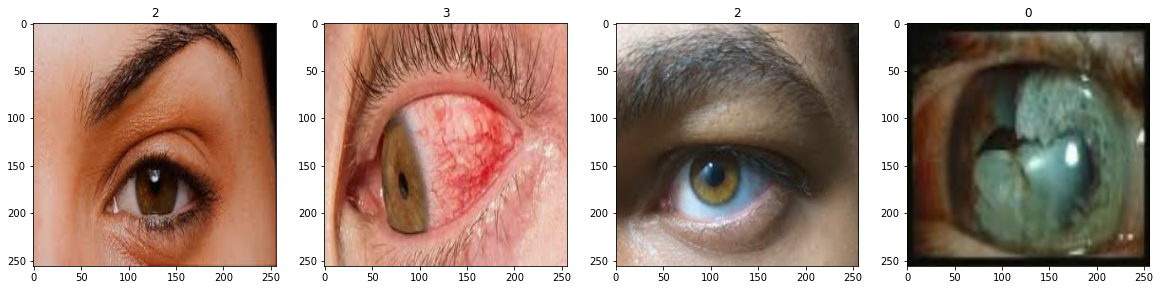

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

CLASSES:
0 = Cataract,
1 = Jaundice,
2 = Normal,
3 = Uveitis

1.3 Scale the Data

In [11]:
data = data.map(lambda x,y: (x/255, y))

In [12]:
scaled_iterator = data.as_numpy_iterator()

In [13]:
batch = scaled_iterator.next()

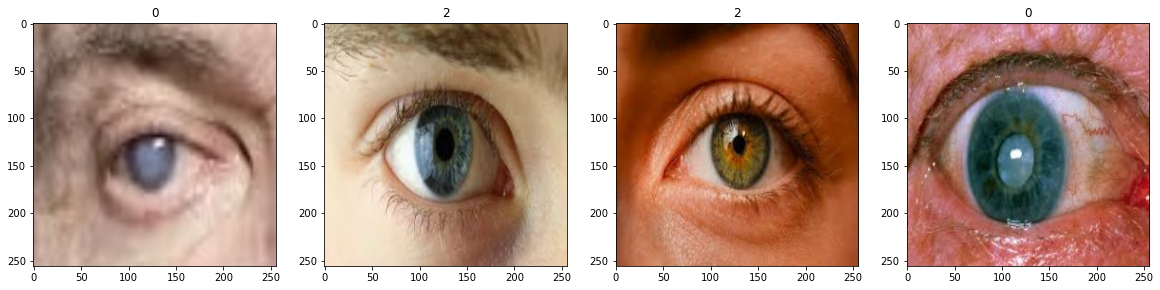

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

1.4 Split the Data

In [15]:
#We have a total of 7 batches of data with 32 images per batch (224 images total)

len(data)

140

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [17]:
print("Number of batches in training:", train_size)
print("Number of batches in validation:", val_size)
print("Number of batches in test:", test_size)

Number of batches in training: 98
Number of batches in validation: 29
Number of batches in test: 15


In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

2. Deep Learning Model

2.1 Build the model

In [19]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
#Augment the dataset with random flip and rotation/Input layer

data_augmented = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(256,256,3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

In [22]:
#Augmented Data Model

model = Sequential([data_augmented,
                    layers.Conv2D(16, (3,3), 1, padding = 'same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, (3,3), 1, padding = 'same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, (3,3), 1, padding = 'same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(256, activation='relu'),
                    layers.Dense(4, activation='sigmoid')
])

In [23]:
model.compile('adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)       

2.2 Train the model

In [25]:
#Create a log directory

logdir = 'C:\Logs'

In [26]:
#Create a callback

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
#Fit the model

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


C:\ProgramData\Anaconda3\envs\conda\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


98/98 [==============================] - 83s 838ms/step - loss: 0.9794 - accuracy: 0.6392 - val_loss: 0.4135 - val_accuracy: 0.8600
Epoch 2/20
98/98 [==============================] - 82s 840ms/step - loss: 0.4099 - accuracy: 0.8440 - val_loss: 0.2099 - val_accuracy: 0.9211
Epoch 3/20
98/98 [==============================] - 85s 868ms/step - loss: 0.1974 - accuracy: 0.9312 - val_loss: 0.0786 - val_accuracy: 0.9767
Epoch 4/20
98/98 [==============================] - 83s 840ms/step - loss: 0.0996 - accuracy: 0.9730 - val_loss: 0.0774 - val_accuracy: 0.9622
Epoch 5/20
98/98 [==============================] - 82s 831ms/step - loss: 0.0737 - accuracy: 0.9750 - val_loss: 0.0501 - val_accuracy: 0.9867
Epoch 6/20
98/98 [==============================] - 83s 851ms/step - loss: 0.1262 - accuracy: 0.9585 - val_loss: 0.0419 - val_accuracy: 0.9956
Epoch 7/20
98/98 [==============================] - 84s 858ms/step - loss: 0.0632 - accuracy: 0.9796 - val_loss: 0.0721 - val_accuracy: 0.9867
Epoch 8/20

3. Evaluation

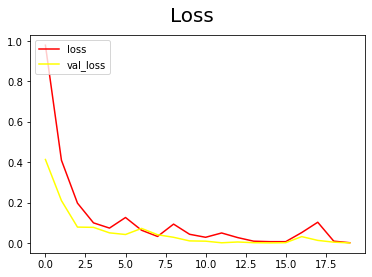

In [28]:
#Performance

fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='yellow', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

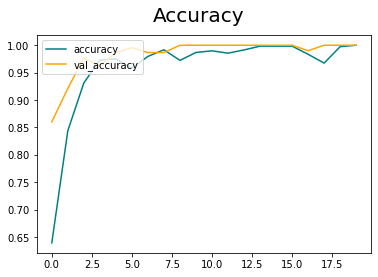

In [29]:
#Accuracy

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

4. Test the Model

In [30]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, Accuracy

In [31]:
#Precision, Recall, and Accuracy looping

pre = Precision()
re = Recall()
acc = Accuracy()

In [32]:
import numpy as np
from keras import backend as K

for batch in test.as_numpy_iterator():
    X, y = batch
    yprime = np.zeros((y.size, 4))
    yprime[np.arange(y.size),y] = 1

    yhat = K.one_hot(K.argmax(model.predict(X)),4)

    #print(yprime)
    #print(yhat)
    #print('\r\n')

    pre.update_state(yprime, yhat)
    re.update_state(yprime, yhat)
    acc.update_state(yprime, yhat)

In [33]:
print(f'Precision Score:{pre.result().numpy()}')
print(f'Recall Score:{re.result().numpy()}')
print(f'Accuracy Score:{acc.result().numpy()}')

Precision Score:1.0
Recall Score:1.0
Accuracy Score:1.0


5. Test

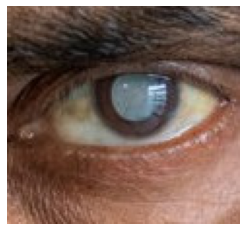

In [34]:
#Load image model has not seen yet.

import matplotlib.image as mpimg

img = mpimg.imread('C:\Git\Projects\eye_diseases\data\\test_images\\cattest2.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


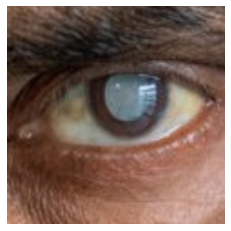

In [35]:
#Resize image

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.axis('off')
plt.show()

CLASSES:
0 = Cataract,
1 = Jaundice,
2 = Normal,
3 = Uveitis

In [36]:
#Make a dictionary

classes = {0: 'Cataract', 1: 'Jaundice', 2: 'Normal', 3: 'Uveitis'}

In [37]:
#Write a function to convert number to label

def convert_to_class(pred):
    try:
        print(classes[pred])
    except KeyError:
        print(f'{pred} is not an index in the class dictionary')

In [38]:
#Predict the image class and return the label

prediction = model.predict(np.expand_dims(resize/255, 0)).argmax()
convert_to_class(prediction)

Cataract
